# Imports

In [0]:
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from lxml import etree
import os
from skimage import io
from skimage.transform import resize
from IPython.display import SVG
import numpy as np
import math
from scipy import ndimage
import matplotlib.pylab as pl
from google.colab import files, drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import backend as K
from keras import metrics, initializers
from keras.regularizers import l1, l2, l1_l2
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.callbacks import ModelCheckpoint
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [0]:
drive.mount('/content/drive/')
path = "drive/My Drive/computer_vision/"

# **Load matrices and plot images**

In [0]:
# load matrices
xtrain = np.load(path+'xtrain_boat_cat128.npy')#, allow_pickle=True)
xval = np.load(path+'xval_boat_cat128.npy')#, allow_pickle=True)
ytrain = np.load(path+'ytrain_boat_cat128.npy')#, allow_pickle=True)
yval = np.load(path+'yval_boat_cat128.npy')#, allow_pickle=True)

Text(0.5, 1.0, 'Cat 2')

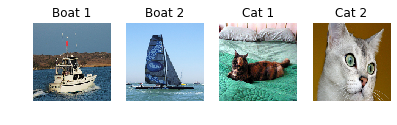

In [0]:
# plot 2 images of each class
pl.figure(1, figsize=(6.4, 3))

pl.subplot(1, 4, 1)
pl.imshow(xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(1, 4, 2)
pl.imshow(xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(1, 4, 3)
pl.imshow(xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(1, 4, 4)
pl.imshow(xtrain[386])
pl.axis('off')
pl.title('Cat 2')

In [0]:
# plot whole training set
pl.figure(1, figsize=(10, 44))
for i in range(len(xtrain)): #size 436 if birds and cats
    pl.subplot(44, 10, i+1)
    pl.imshow(xtrain[i])
    pl.axis('off')
    pl.title(str(i))



In [0]:
# plot whole validation set
pl.figure(1, figsize=(10, 44))
for i in range(len(xval)): #size 432 if boats and cats
    pl.subplot(44, 10, i+1)
    pl.imshow(xval[i])
    pl.axis('off')
    pl.title(str(i))

# **Auto-encoders**


## PCA vs Auto-encoders


PCA aim: find a few directions in the input space explaining the variation in the input data; project the data onto those dimentionss

--> linear relationship between the data and the learned representation

Here 2 PCs used (reduction from dimension 137388 to 2; of course bad, but to be able to plot)





AE: NN whose outputs are its own inputs; same objective function as PCA

Goal = minimize reconstruction error

inputs x --> lower dim z = f(Wx) --> reconstruction higher dim ~x = g(Vz)

goal --> min sum (x - ~x)^2 

         --> = min sum (x - VWx)^2        if f and g are linear
         
                      => optimal solution is PCA
                      
2 neurons in hidden layer --> approximate to reducing data to 2 features

With linear activation function and a single hidden layer of size p, the weights of the AE span the same vector subspace as the one spanned by the first p components of PCA, and the output of AE is an orthogonal projection onto this subspace

/!\ AE weights != PCs --> in general weights not orthogonal but the PCs can be recovered using Singular Value Decomposition (Plaut, E.,From Principal Subspaces to Principal Components with Linear Autoencoders, Arxiv.org:1804.10253.)

--> to compare PCA and AE, compare reconstruction error


From visual evaluation here PCA is better than linear AE
From reconstruction error comparison here PCA is better than linear AE



- the autoencoder is better at reconstructing the original data set than PCA when p is small (but the error converges as p increases) --> for very large data sets this difference will be larger --> means that same accuracy can be achieved with less components than for PCA and hence a smaller data set

- in PCA, we can choose the #PCs based on the % of variability they explain; with AE, we don't know how many to keep (can you PCA to determine how many neurons in hidden layer)


- better visualization possible with AE than with PCA



### PCA

In [0]:
# reshape: 153 x 256*256*3 = 153 x 196608 # cats&birds 528 not 153
# if 128 --> 49152
xrs = xtrain.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))
# scale (mean-center)
# scaler = StandardScaler()
# scaler.fit(xrs)
# xscaled = scaler.transform(xrs)
# centering done in decomposition.PCA method BUT NEED TO SCALE FOR LINEAR AUTOENCODER (CAE no, use 3D img)
# no need to scale as all same scale (all values represent a pixel)
# already between 0 and 1
xscaled = xrs
xvrs = xval.reshape(len(xval), len(xval[0])*len(xval[0,0])*len(xval[0,0,0]))
# use scaler fitted on xtrain because no assumptions about xval
# xvscaled = scaler.transform(xvrs)
xvscaled = xvrs

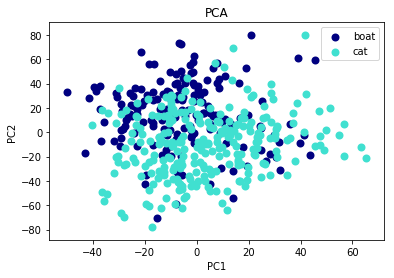

In [0]:
# PCA
pca = PCA()
pca_transformed = pca.fit_transform(xscaled)

# Get first 2 PCs
pca_2pcs = pca_transformed[:,:2]

# Plot 2 PCs of PCA
plt.figure()
lw = 2
for i in range(170):
  if i==0:
    plt.scatter(pca_2pcs[i, 1], pca_2pcs[i, 0], color='navy', alpha=1., lw=lw,
                label='boat')
  else: # otherwise one point per sample in legend
    plt.scatter(pca_2pcs[i, 1], pca_2pcs[i, 0], color='navy', alpha=1., lw=lw)
    
for i in range(266):
  if i==0:
    plt.scatter(pca_2pcs[170+i, 1], pca_2pcs[170+i, 0], color='turquoise', alpha=1.,
                lw=lw, label='cat')
  else:
    plt.scatter(pca_2pcs[170+i, 1], pca_2pcs[170+i, 0], color='turquoise', alpha=1.,
                lw=lw)
   
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')  
plt.xlabel('PC' + "1")
plt.ylabel('PC' + "2")
plt.show()


Text(0, 0.5, 'Cumulative explained variance')

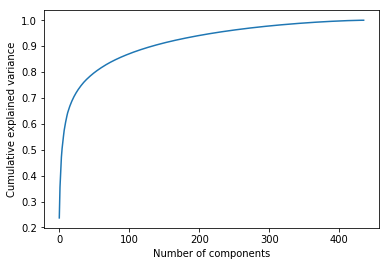

In [0]:
#print(pca.explained_variance_ratio_) 

# not fast and big increase in cumsum --> var distributed over a lot of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

### PCA reconstructions with diff #PCs

0.046534553


Text(0.5, 1.0, 'Cat 2')

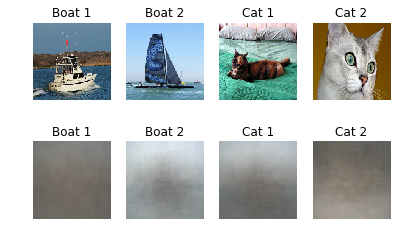

In [0]:
# Reconstruction with N components
pca = PCA(n_components=2) #N
pca_transformed = pca.fit_transform(xscaled)
inv_pca = pca.inverse_transform(pca_transformed)
inv_xtrain = inv_pca.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,inv_pca))


# plot 2 images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[386])
pl.axis('off')
pl.title('Cat 2')

pl.subplot(2, 4, 5)
pl.imshow(inv_xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 6)
pl.imshow(inv_xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 7)
pl.imshow(inv_xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 8)
pl.imshow(inv_xtrain[386])
pl.axis('off')
pl.title('Cat 2')

### Linear AE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 98306     
_________________________________________________________________
dense_4 (Dense)              (None, 49152)             147456    
Total params: 245,762
Trainable params: 245,762
Non-trainable params: 0
_________________________________________________________________
None


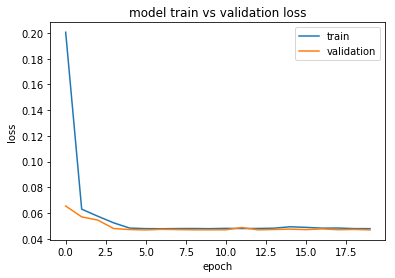

In [0]:
# Create an AE and fit it with the data using 2 neurons in the hidden layer (to compare with 2 PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                         verbose=0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

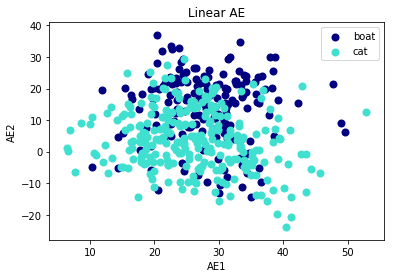

In [0]:
# Get first 2 features --> weight vectors
ae_weights = encoded_data[:,:2] # normally already shape (153, 2) with 2 neurons

# Plot the 2 weight vectors of AE
plt.figure()
lw = 2
for i in range(170):
  if i==0:
    plt.scatter(ae_weights[i, 0], ae_weights[i, 1], color='navy', alpha=1., lw=lw,
                label='boat')
  else: # otherwise one point per sample in legend
    plt.scatter(ae_weights[i, 0], ae_weights[i, 1], color='navy', alpha=1., lw=lw)
    
for i in range(266):
  if i==0:
    plt.scatter(ae_weights[170+i, 0], ae_weights[170+i, 1], color='turquoise', alpha=1.,
                lw=lw, label='cat')
  else:
    plt.scatter(ae_weights[170+i, 0], ae_weights[170+i, 1], color='turquoise', alpha=1.,
                lw=lw)
   
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Linear AE')  
plt.xlabel('AE' + "1")
plt.ylabel('AE' + "2")
plt.show()

Linear AE very similar to PCA --> same subspace spanned

### Reconstruction AE diff #neurons

In [0]:
# Create an AE and fit it with the data using N neurons in the hidden layer (to compare with N PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 436  # N
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                verbose = 0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

decoded_data = autoencoder.predict(xscaled)
decoded_imgs = decoded_data.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_data))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[386])
pl.axis('off')
pl.title('Cat 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[386])
pl.axis('off')
pl.title('Cat 2')

## Non-linear and convolutional AE

W0617 15:28:54.908169 139886258935680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 15:28:54.926352 139886258935680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 15:28:54.931329 139886258935680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 15:28:54.950908 139886258935680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 15:28:54.988506 139886258935680 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 8)         0         
__________

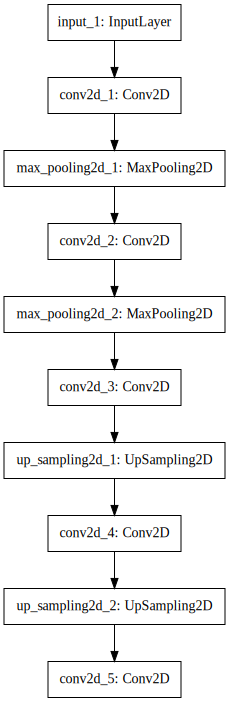

In [0]:
# Convolutional AE: use images in 3D, not flattened
# AE1
# size code --> /4

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
#net = Dropout(0.25)(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions 

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

#plot_model(autoencoder, to_file=path+'autoencoder.png', show_shapes=True)
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

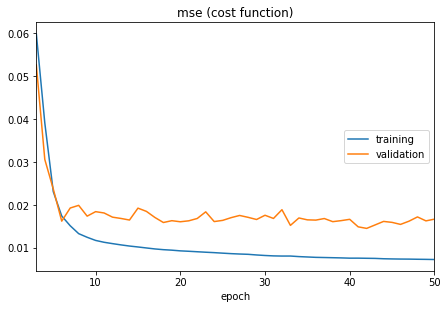

mse (cost function):
training   (min:    0.007, max:    0.075, cur:    0.007)
validation (min:    0.015, max:    0.071, cur:    0.017)


In [0]:
history = autoencoder.fit(xtrain, xtrain,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                         verbose=0,
                         callbacks=[PlotLossesKeras()])



0.0167772


Text(0.5, 1.0, 'Cat 2')

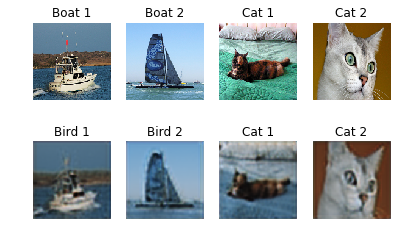

In [0]:
decoded_imgs = autoencoder.predict(xtrain)
decoded_rs = decoded_imgs.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_rs))

#decoded_imgs = autoencoder.predict(xval)
#decoded_vrs = decoded_imgs.reshape(len(xval), len(xval[0])*len(xval[0,0])*len(xval[0,0,0]))

#print(mean_squared_error(xvrs,decoded_rs))
# --> same error on validation set (from previous plot, we see that the two errors converge)


# plot 2 images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[386])
pl.axis('off')
pl.title('Cat 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[8])
pl.axis('off')
pl.title('Bird 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[14])
pl.axis('off')
pl.title('Bird 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[386])
pl.axis('off')
pl.title('Cat 2')

32


Text(0.5, 1.0, 'Cat 2')

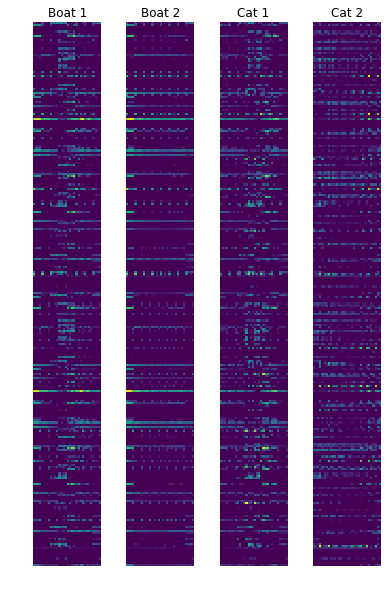

In [0]:
# Show encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/4)
print(s)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[8].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[14].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[323].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[286].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 2')

### To do

TO DO if we want: greedy layer-wise training (see ANN exercise session 3)

1) Train 1st layer as AE with 1 hidden layer

2) Predict encoder part with training data 
          
          features = encoder.predict(xtrain)
          
3) Train 2nd layer as AE with 1 hidden layer, and use features as input

4) Predict encoder part

5) Train 3rd layer as AE with 1 hidden layer, and use features obtained in step 4

etc.


# Classification

### Classifier from auto-encoder

In [0]:
# Classifier using AE with 2 conv layers in encoder
# size code --> /4

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 
# 196608 dimensions if 256
# 49152 if 128


net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions if 256
  # (16, 16, 8) --> 2018 if 128

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0)

# 
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
#encoder.save(path+'AE1model.h5')
#encoder.save_weights(path+'AE1weights.h5')

encoder_frozen = load_model(path+'AE1modelDeep2.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid')(net) #  simple logistic regression
  # not softmax because we could have a multi-label image, with both sheeps and cows
  # softmax --> only one label
  # probably no images with both cats and boats? --> try softmax
classifier = Model(encoder_frozen.input, classOut)
print(classifier.summary())

#plot_model(classifier, to_file=path+'classifier.png', show_shapes=True)
SVG(model_to_dot(classifier).create(prog='dot', format='svg'))

#autoencoder = Model(input_img, classOut)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSig.h5')

### Fine-tuning of classifier from auto-encoder

In [0]:
# Fine-tuning: retrain whole classifier when unfreezing the encoder part

classifier = load_model(path+'classifierAdamSig.h5')
                      
for layer in classifier.layers:
    layer.trainable = True
    
    
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = classifier.fit(xtrain, ytrain, #x, y,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval), #validation_split=0.1,
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSigTuned.h5')



In [0]:
# Show encoded representations of the same 4 images as previously
encoder = load_model(path+'AE1model.h5')
encoded_imgs = encoder.predict(xtrain)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/4)
print(s)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[8].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[14].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[323].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[286].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 2')

### Classifier trained from scratch

In [0]:
# From scratch: same architectures but initial random weights (i.e. not from auto-encoder training)


#encoder_randomw = load_model(path+'AE1model.h5')
#for layer in encoder_randomw.layers:
#  layer.trainable = True
#  if hasattr(layer, 'kernel_initializer'):
#            layer.kernel_initializer = 'random_uniform'
#            layer.bias_initializer = 'zeros'
# then flatten and dense --> same

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)
  
net = Flatten()(encoded)
classOut = Dense(2, activation='sigmoid')(net) 
classifier = Model(input_img, classOut)
print(classifier.summary())

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSigScratch.h5')

### Classifier from greedy layer-wise trained auto-encoder

In [0]:
# Greedy layer-wise training of the auto-encoder

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded1 = MaxPooling2D((2, 2), padding='same')(net)


net = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded1)
net = UpSampling2D((2, 2))(net)
decoded1 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adam', loss='mse')


print(autoencoder1.summary())

history = autoencoder1.fit(xtrain, xtrain,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0)

encoder1 = Model(input_img, encoded1)
encoded_imgs1 = encoder1.predict(xtrain)

print(encoded_imgs1.shape)


encoded_imgs1val = encoder1.predict(xval)

#input2 = Input(shape=(64,64,16)) 

net = Conv2D(8, (3, 3), activation='relu', padding='same')(input2)
encoded2 = MaxPooling2D((2, 2), padding='same')(net)

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded2)
net = UpSampling2D((2, 2))(net)
decoded2 = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder2 = Model(input2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')


print(autoencoder2.summary())

history = autoencoder2.fit(encoded_imgs1, encoded_imgs1,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(encoded_imgs1val, encoded_imgs1val),
                verbose=0)

encoder2 = Model(input2, encoded)
encoded_imgs2 = encoder2.predict(encoded_imgs1)

print(encoded_imgs2.shape)


for layer in encoder1.layers:
  layer.trainable = False
  
for layer in encoder2.layers:
  layer.trainable = False
  
  
#encoded_imgs2 = encoder2.predict(encoder1.predict(xtrain))

net = Flatten()(encoder2.output)
classOut = Dense(2, activation='sigmoid')(net) 
classifier = Model(encoder2.input, classOut)
print(classifier.summary())

SVG(model_to_dot(classifier).create(prog='dot', format='svg'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history = classifier.fit(encoder1.predict(xtrain), ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(encoder1.predict(xval), yval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'greedyClassifier.h5')

### Deeper CNN classifiers (no auto-encoder i.e. from scratch)

In [0]:
# Deeper CNN

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

net = Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
net = MaxPooling2D((4, 4), padding='same')(net)
net = Conv2D(128, (3, 3), activation='relu', padding='same')(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(256, (3, 3), activation='relu', padding='same')(net)
net = Conv2D(256, (3, 3), activation='relu', padding='same')(net)
net = Conv2D(128, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

net = Flatten()(encoded)
classOut = Dense(2, activation='sigmoid')(net)
classifier = Model(input_img, classOut)
print(classifier.summary())

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierDeep.h5')
#plot_model(classifier, to_file=path+'classifierDeep.png', show_shapes=True)

## Trying to decrease overfitting

### More training data

In [0]:
# More training data, less validation: 80-20% split

encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid')(net)
classifier = Model(encoder_frozen.input, classOut)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

x = np.append(xtrain, xval, axis=0)
y = np.append(ytrain, yval, axis=0)

# 80% of the 436+432 training data, 20% validation data

history = classifier.fit(x, y,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose=0,
                callbacks=[PlotLossesKeras()])


### L1 & L2 regularization

In [0]:
# L1 regularization

encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  if hasattr(layer, 'activity_regularizer'):
            layer.activity_regularizer=l1(0.05) # 0.01 0.05 0.1
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid', activity_regularizer=l1(0.05))(net) # 0.01 0.05 0.1
classifier = Model(encoder_frozen.input, classOut)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

x = np.append(xtrain, xval, axis=0)
y = np.append(ytrain, yval, axis=0)


history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval), 
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSigL1.h5')

In [0]:
# L2 regularization

encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  if hasattr(layer, 'activity_regularizer'):
            layer.activity_regularizer=l2(0.05) # 0.01 0.05 0.1
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid', activity_regularizer=l2(0.05))(net) # 0.01 0.05 0.1
classifier = Model(encoder_frozen.input, classOut)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

x = np.append(xtrain, xval, axis=0)
y = np.append(ytrain, yval, axis=0)

history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval), 
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSigL2.h5')

In [0]:
# L1 & L2 regularization

encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  if hasattr(layer, 'activity_regularizer'):
            layer.activity_regularizer=l1_l2(0.02, 0.02)
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid', activity_regularizer=l1_l2(0.02, 0.02))(net)
classifier = Model(encoder_frozen.input, classOut)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

x = np.append(xtrain, xval, axis=0)
y = np.append(ytrain, yval, axis=0)

history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval), 
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSigL1L2.h5')

### Dropout & Batch normalization

In [0]:
# Add Dropout layers in encoder 
# to do: check reconstruction
# --> autoencoder not symmetric anymore --> dropout in decoder as well?

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Dropout(0.4)(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0)

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
encoder.save(path+'AE1model_dropout.h5')

for layer in encoder.layers:
  layer.trainable = False

net = Flatten()(encoder.output)
classOut = Dense(2, activation='sigmoid')(net)
classifier = Model(encoder.input, classOut)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifier_dropout.h5')

In [0]:
# Batch normalization 

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 


net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = BatchNormalization()(net)
net = MaxPooling2D((2, 2), padding='same')(net)
#net = Dropout(0.4)(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = BatchNormalization()(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0)

 
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
encoder.save(path+'AE1model_batchnorm.h5')

#autoencoder = Model(input_img, classOut)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = classifier.fit(xtrain, ytrain,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(xval, yval),
                verbose=0,
                callbacks=[PlotLossesKeras()])

classifier.save(path+'classifier_batchnorm.h5')

### Data augmentation

In [0]:
xtrainIN = np.load(path+'xtrainIN.npy')#, allow_pickle=True)
ytrainIN = np.load(path+'ytrainIN.npy')#, allow_pickle=True)
xvalIN = np.load(path+'xvalIN.npy')#, allow_pickle=True)
yvalIN = np.load(path+'yvalIN.npy')#, allow_pickle=True)

In [0]:
# Data augmentation
encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
  
  
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid')(net)
classifier = Model(encoder_frozen.input, classOut)
print(classifier.summary())

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


#history = classifier.fit(xtrain, ytrain,
 #               epochs=100,
  #              batch_size=32,
   #             shuffle=True,
    #            validation_data=(xval, yval),
     #           verbose=0,
      #          callbacks=[PlotLossesKeras()])

#classifier.save(path+'classifierAdamSig.h5')

datagen = ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    shear_range=0.15,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(xtrain)

# fits the model on batches with real-time data augmentation:
history = classifier.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32), validation_data=(xval,yval),
                    steps_per_epoch=len(xtrain)/32, epochs=100, validation_steps=len(xval)/32,
                callbacks=[PlotLossesKeras()])

### Using pre-trained networks

In [0]:
# Transfer learning using ImageNet --> CNN

#base_model=obileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
model = VGG16(weights="imagenet")
net=model.output
#net=GlobalAveragePooling2D()(net)
#net=Dense(1024,activation='relu')(net) #we add dense layers so that the model can learn more complex functions and classify for better results.
#net=Dense(1024,activation='relu')(net) #dense layer 2
#net=Dense(512,activation='relu')(net) #dense layer 3
preds=Dense(2,activation='sigmoid')(net) #final layer with sigmoid activation #120

imgNetModel=Model(inputs=model.input,outputs=preds)

print(imgNetModel.summary())

# if we want all layers except dense layers not trainable
#for layer in imgNetModel.layers:
#    layer.trainable=False
# if we want to set the first 20 layers of the network to be non-trainable
#for layer in imgNetModel.layers[:20]:
#    layer.trainable=False
for layer in imgNetModel.layers:#[20:]:
    layer.trainable=True

imgNetModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = imgNetModel.fit(xtrainIN, ytrainIN,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(xvalIN, yvalIN),
                verbose=0,
                callbacks=[PlotLossesKeras()])

preds = imgNetModel.predict(preprocess_input(xvalIN))
print(preds)

Pre-trained network... not working: 60\% accuracy

TO DO:
- try pre-trained network
- try sparse auto-encoder?
- try CNN
- try RBM?
- GAN? can it be used for classification
- Variational autoencoder?

# Image Segmentation


good link for most know techniques

https://medium.com/@arthur_ouaknine/review-of-deep-learning-algorithms-for-image-semantic-segmentation-509a600f7b57

## Load data and Images visualization

In [0]:
xtrain = np.load(path+'x_train_seg_all224.npy')
xval = np.load(path+'x_val_seg_all224.npy')
yval = np.load(path+'y_val_seg_all224.npy')
ytrain = np.load(path+'y_train_seg_all224.npy')

In [0]:
# plot 2 "good" images of each class
ratio = 15
pl.figure(1, figsize=(1*ratio, 4*ratio))

pl.subplot(1, 4, 1)
pl.imshow(xtrain[0])
pl.axis('off')


pl.subplot(1, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')


pl.subplot(1, 4, 3)
pl.imshow(xtrain[2])
pl.axis('off')


pl.subplot(1, 4, 4)
pl.imshow(xtrain[3])
pl.axis('off')


In [0]:
# plot 2 "good" images of each class
ratio = 15
pl.figure(1, figsize=(1*ratio, 4*ratio))

pl.subplot(1, 4, 1)
pl.imshow(ytrain[0])
pl.axis('off')


pl.subplot(1, 4, 2)
pl.imshow(ytrain[1])
pl.axis('off')


pl.subplot(1, 4, 3)
pl.imshow(ytrain[2])
pl.axis('off')


pl.subplot(1, 4, 4)
pl.imshow(ytrain[3])
pl.axis('off')


## Image pre processing


In [0]:
# preprocess segmentation to binary images

ytrain_bin = np.zeros((ytrain.shape[0],ytrain.shape[1],ytrain.shape[2],2))
ytrain_bin_plot = np.zeros((ytrain.shape[0],ytrain.shape[1],ytrain.shape[2]))
yval_bin = np.zeros((yval.shape[0],yval.shape[1],yval.shape[2],2))
yval_bin_plot = np.zeros((yval.shape[0],yval.shape[1],yval.shape[2]))

for i in range(ytrain.shape[0]):
  for j in range(ytrain.shape[1]):
    for k in range(ytrain.shape[2]):
      if ytrain[i][j][k][0] ==  0.0 and ytrain[i][j][k][1] ==  0.0: 
        ytrain_bin[i][j][k] = [1, 0]
        ytrain_bin_plot[i][j][k] = 1
      else:
        ytrain_bin[i][j][k] = [0, 1]
        
for i in range(yval.shape[0]):
  for j in range(yval.shape[1]):
    for k in range(yval.shape[2]):
      if yval[i][j][k][0] ==  0.0 and yval[i][j][k][1] ==  0.0: 
        yval_bin[i][j][k] = [1, 0]
        yval_bin_plot[i][j][k] = 1
      else:
        yval_bin[i][j][k] = [0, 1]
              

In [0]:
ratio = 15
pl.figure(1, figsize=(1*ratio, 4*ratio))

pl.subplot(1, 4, 1)
pl.imshow(ytrain_bin_plot[0])
pl.axis('off')
#pl.title('Sheep 1')

pl.subplot(1, 4, 2)
pl.imshow(ytrain_bin_plot[1])
pl.axis('off')
#pl.title('Sheep 2')

pl.subplot(1, 4, 3)
pl.imshow(ytrain_bin_plot[2])
pl.axis('off')
#pl.title('Cow 1')

pl.subplot(1, 4, 4)
pl.imshow(ytrain_bin_plot[3])
pl.axis('off')
#pl.title('Cow 2')

## FCN model

Fully convolutional networks for semantic segmentation

In [0]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")  

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

In [0]:
## location of VGG weights
VGG_Weights_path = path + "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [0]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

n_classes = 2;
  
model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

#plot_model(model, to_file=path+'FCN8.png', show_shapes=True)

In [0]:
from keras import optimizers

epochs_n = 100 #50 #200

sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', #categorical_crossentropy binary_crossentropy
              optimizer=sgd, #sgd
              metrics=['accuracy'])

hist1 = model.fit(xtrain,ytrain_bin,
                  validation_data=(xval,yval_bin),
                  batch_size=32,epochs=epochs_n,verbose=2)

In [0]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
    plt.title("categorical cross entropy (cost function)")
    plt.xlabel('epoch')
plt.legend()
plt.show()

In [0]:
for key in ['acc', 'val_acc']:
    plt.plot(hist1.history[key],label=key)
    plt.title("Accuracy")
    plt.xlabel('epoch')
plt.legend()
plt.show()

In [0]:
y_pred = model.predict(xval)
y_predi = np.argmax(y_pred, axis=3)
y_vali = np.argmax(yval_bin, axis=3)

print(y_vali.shape,y_predi.shape)

## Metrics and results


In [0]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_vali,y_predi)

In [0]:
def Dice_score(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = 2TP/(FN + 2TP + FP)

    Dices = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        Dice = 2*TP/float(2*TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, Dice score={:4.3f}".format(c,TP,FP,FN,Dice))
        Dices.append(Dice)
    mDice = np.mean(Dices)
    print("_________________")
    print("Mean Dice score: {:4.3f}".format(mDice))
    
Dice_score(y_vali,y_predi)

In [0]:
import seaborn as sns

In [0]:
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [0]:
shape = (224,224)
n_classes= 2 #10

for i in range(10):
    img_is  = (xval[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_vali[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()